In [ ]:
ANother approach using Keras Pretrained models

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir, makedirs
from os.path import join, exists, expanduser
from tqdm import tqdm
from sklearn.metrics import log_loss, accuracy_score
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications import xception
from keras.applications import inception_v3
from keras.applications.vgg16 import preprocess_input, decode_predictions
from sklearn.linear_model import LogisticRegression



Using TensorFlow backend.


In [2]:


start = dt.datetime.now()



In [3]:
!ls
!ls


deep-learning-models  Dogbreedclassification.ipynb  keraspretrain
deep-learning-models  Dogbreedclassification.ipynb  keraspretrain


In [4]:
cache_dir = expanduser(join('~', '.keras'))
if not exists(cache_dir):
    makedirs(cache_dir)
models_dir = join(cache_dir, 'models')
if not exists(models_dir):
    makedirs(models_dir)

In [5]:
!cp keraspretrain/*notop* ~/.keras/models/
!cp keraspretrain/imagenet_class_index.json ~/.keras/models/
!cp keraspretrain/resnet50* ~/.keras/models/

In [6]:
!ls ~/.keras/models

imagenet_class_index.json
inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5
inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
resnet50_weights_tf_dim_ordering_tf_kernels.h5
resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
xception_weights_tf_dim_ordering_tf_kernels_notop.h5


In [7]:
INPUT_SIZE = 224
NUM_CLASSES = 20
SEED = 1987
data_dir = '../../Data/Dogbreedclassifier/'
labels = pd.read_csv(join(data_dir, 'labels.csv'))
sample_submission = pd.read_csv(join(data_dir, 'sample_submission.csv'))
print(len(listdir(join(data_dir, 'train'))), len(labels))
print(len(listdir(join(data_dir, 'test'))), len(sample_submission))

10222 10222
10357 10357


In [8]:
selected_breed_list = list(labels.groupby('breed').count().sort_values(by='id', ascending=False).head(NUM_CLASSES).index)
labels = labels[labels['breed'].isin(selected_breed_list)]
labels['target'] = 1
labels_pivot = labels.pivot('id', 'breed', 'target').reset_index().fillna(0)
np.random.seed(seed=SEED)
rnd = np.random.random(len(labels))
train_idx = rnd < 0.8
valid_idx = rnd >= 0.8
y_train = labels_pivot[selected_breed_list].values
ytr = y_train[train_idx]
yv = y_train[valid_idx]



In [9]:
def read_img(img_id, train_or_test, size):
    """Read and resize image.
    # Arguments
        img_id: string
        train_or_test: string 'train' or 'test'.
        size: resize the original image.
    # Returns
        Image as numpy array.
    """
    img = image.load_img(join(data_dir, train_or_test, '%s.jpg' % img_id), target_size=size)
    img = image.img_to_array(img)
    return img


KeyError: 'rank'

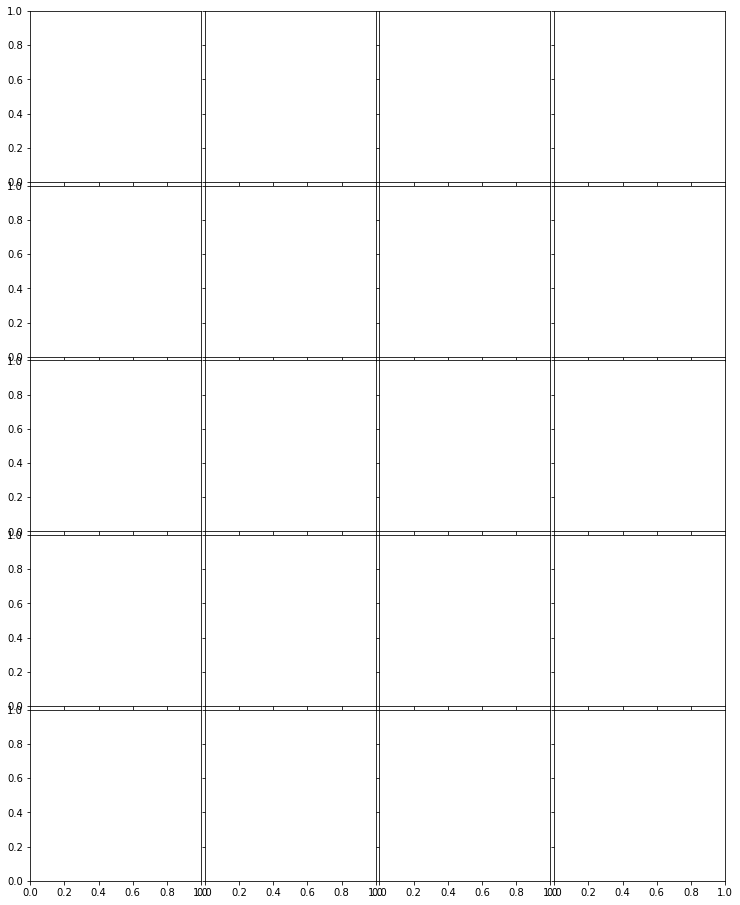

In [20]:
model = ResNet50(weights='imagenet')
j = int(np.sqrt(NUM_CLASSES))
i = int(np.ceil(1. * NUM_CLASSES / j))
fig = plt.figure(1, figsize=(16, 16))
grid = ImageGrid(fig, 111, nrows_ncols=(i, j), axes_pad=0.05)
for i, (img_id, breed) in enumerate(labels.loc[labels['rank'] == 1, ['id', 'breed']].values):
    ax = grid[i]
    img = read_img(img_id, 'train', (224, 224))
    ax.imshow(img / 255.)
    x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    preds = model.predict(x)
    _, imagenet_class_name, prob = decode_predictions(preds, top=1)[0][0]
    ax.text(10, 180, 'ResNet50: %s (%.2f)' % (imagenet_class_name , prob), color='w', backgroundcolor='k', alpha=0.8)
    ax.text(10, 200, 'LABEL: %s' % breed, color='k', backgroundcolor='w', alpha=0.8)
    ax.axis('off')
plt.show()


In [ ]:
INPUT_SIZE = 224
POOLING = 'avg'
x_train = np.zeros((len(labels), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, img_id in tqdm(enumerate(labels['id'])):
    img = read_img(img_id, 'train', (INPUT_SIZE, INPUT_SIZE))
    x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_train[i] = x
print('Train Images shape: {} size: {:,}'.format(x_train.shape, x_train.size))

2184it [00:19, 111.06it/s]

Train Images shape: (2184, 224, 224, 3) size: 328,753,152


In [ ]:
Xtr = x_train[train_idx]
Xv = x_train[valid_idx]
print((Xtr.shape, Xv.shape, ytr.shape, yv.shape))
vgg_bottleneck = VGG16(weights='imagenet', include_top=False, pooling=POOLING)
train_vgg_bf = vgg_bottleneck.predict(Xtr, batch_size=32, verbose=1)
valid_vgg_bf = vgg_bottleneck.predict(Xv, batch_size=32, verbose=1)
print('VGG train bottleneck features shape: {} size: {:,}'.format(train_vgg_bf.shape, train_vgg_bf.size))
print('VGG valid bottleneck features shape: {} size: {:,}'.format(valid_vgg_bf.shape, valid_vgg_bf.size))



((1732, 224, 224, 3), (452, 224, 224, 3), (1732, 20), (452, 20))


In [ ]:


logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
logreg.fit(train_vgg_bf, (ytr * range(NUM_CLASSES)).sum(axis=1))
valid_probs = logreg.predict_proba(valid_vgg_bf)
valid_preds = logreg.predict(valid_vgg_bf)



In [ ]:


print('Validation VGG LogLoss {}'.format(log_loss(yv, valid_probs)))
print('Validation VGG Accuracy {}'.format(accuracy_score((yv * range(NUM_CLASSES)).sum(axis=1), valid_preds)))


